## Q learning with the CartPole-v1 using Monte Carlo

For a detailed description of the cartpole env, refer to [this](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) site

In [15]:
import numpy as np 
import gym

### Configuring the display using matplotlib

In [16]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Description

#### Action space

The action is an `ndarray` with shape `(1,)` which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

#### State Space

The observation is an `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num |      Observation      |         Min         |        Max        |   |
|:---:|:---------------------:|:-------------------:|:-----------------:|---|
| 0   | Cart Position         | -4.8                | 4.8               |   |
| 1   | Cart Velocity         | -Inf                | Inf               |   |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |   |
| 3   | Pole Angular Velocity | -Inf                | Inf               |   |

#### Rewards

Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken, including the termination step, is allotted. The threshold for rewards is `475` for v1.

#### Starting State

All observations are assigned a uniformly random value in (-0.05, 0.05)

#### Episode

The episode ends if any one of the following occurs:

- `Termination`: Pole Angle is greater than ±12°</li>
- `Termination`: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)</li>
- `Truncation`: Episode length is greater than 500 (200 for v0)</li>


### The policy functions

#### a. Fixed 

In [99]:
policy_fixed = lambda pos, vel, angle, omega, _: 1

#### b. Random

In [100]:
policy_random = lambda pos, vel, angle, omega, _: np.random.randint(2)

#### c. Based on angular velocity

In [101]:
policy_angular_vel = lambda pos, vel, angle, omega, _: int(omega > 0)

### Experimenting

In [135]:
env = gym.make("CartPole-v1", render_mode="rgb_array", new_step_api=True)

### Discretizer

In [104]:
from sklearn.preprocessing import KBinsDiscretizer
import math
from typing import Tuple

In [105]:
n_bins = ( 6 , 12 )
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:
    """Convert continues state intro a discrete state"""
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))

In [106]:
Q_table = np.zeros(n_bins + (env.action_space.n,))
Q_table.shape

(6, 12, 2)

#### Define the policy

In [128]:
def policy( state : tuple ):
    """Choose the best next action greedily"""
    return np.argmax(Q_table[state])

#### Update q-table

In [109]:
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    """Temporal difference for updating Q-value of state-action pair"""
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

#### Learning rate

In [127]:
def learning_rate(n : int) -> float  :
    """Decaying learning rate"""
    return 1 / n

#### Exploration

In [111]:
def exploration_rate(n : int) -> float :
    """Decaying exploration rate"""
    return 1 / n

### The runner

In [122]:
env_rgb = lambda rendered_list: np.array(rendered_list).squeeze()

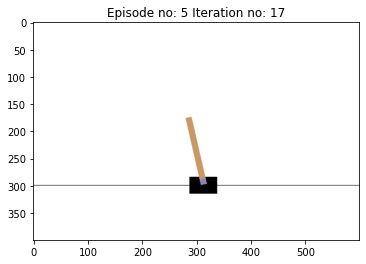

In [130]:
n_episodes = 5

for e in range(n_episodes):
    
    # Discretize state into buckets
    current_state = discretizer(*env.reset())
    img = plt.imshow(env_rgb(env.render()))
    
    iters = 1
    done = False
    
    while not done:
        # greedy action 
        action = policy(current_state) # exploit
        
        # random action
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() # explore 
         
        # Take a step in the enviroment
        obs, reward, done, _, _ = env.step(action)
        new_state = discretizer(*obs)
        
        # Update the display
        plt.title(f"Episode no: {e+1} Iteration no: {iters}")       
        img.set_data(env_rgb(env.render()))
        display.display(plt.gcf())
        display.clear_output(wait=True) 
        
        # Update the q-table
        lr = learning_rate(e + 1)
        learnt_value = new_Q_value(reward , new_state)
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        
        # Iterative updates
        current_state = new_state
        iters += 1